# UEC実践ソフトウェア開発基礎論2023-レポート課題3
田中久温

## データについてメモ
データ取得元: https://archive.ics.uci.edu/dataset/222/bank+marketing

## 概要
銀行，電話によるダイマ，ユーザが定期預金を契約したか2値分類

複数回電話かけたりもしてる

一応元データの attibute information で全部のカテゴリ変数に unknown も含むようなことを書いているので，データになくても，実運用の場合は考えないといけなさそう．

## 方針
とりあえず，レポート課題1でやった特徴量を全部つっこんで精度を見て，解釈をしてみる．

その後，実環境で使うとまずい変数を除いて，モデルを作って，何が効くのかみてみる．

課題1と被る部分があるので，すでに課題1の notebook に書いてあった考察の行頭に，@1 をつける

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/uec2023-3/sample_submission.csv
/kaggle/input/uec2023-3/train_df.csv
/kaggle/input/uec2023-3/test_df.csv


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_df = pd.read_csv('../input/uec2023-3/train_df.csv')
test_df = pd.read_csv('../input/uec2023-3/test_df.csv')

## EDA
課題1と同じことをやる．

In [4]:
train_df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,NaN,0,NaN,0
1,1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,NaN,0,NaN,0
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,NaN,0,NaN,0
3,3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,NaN,0,NaN,0
4,4,35,management,married,tertiary,no,231,yes,no,NaN,5,may,139,1,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36164,36164,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,NaN,0,NaN,1
36165,36165,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,NaN,0,NaN,1
36166,36166,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,NaN,0,NaN,1
36167,36167,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184.0,3,success,1


In [5]:
test_df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,36169,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,NaN,0,NaN
1,36170,43,technician,single,secondary,no,593,yes,no,NaN,5,may,55,1,NaN,0,NaN
2,36171,57,services,married,secondary,no,162,yes,no,NaN,5,may,174,1,NaN,0,NaN
3,36172,33,services,married,secondary,no,0,yes,no,NaN,5,may,54,1,NaN,0,NaN
4,36173,40,retired,married,primary,no,0,yes,yes,NaN,5,may,181,1,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9037,45206,25,services,single,secondary,no,199,no,no,cellular,16,nov,173,1,92.0,5,failure
9038,45207,59,management,married,tertiary,no,138,yes,yes,cellular,16,nov,162,2,187.0,5,failure
9039,45208,34,blue-collar,single,secondary,no,1475,yes,no,cellular,16,nov,1166,3,530.0,12,other
9040,45209,73,retired,married,secondary,no,2850,no,no,cellular,17,nov,300,1,40.0,8,failure


@1 そういえば性別にあたるデータがない．

## age

<Axes: >

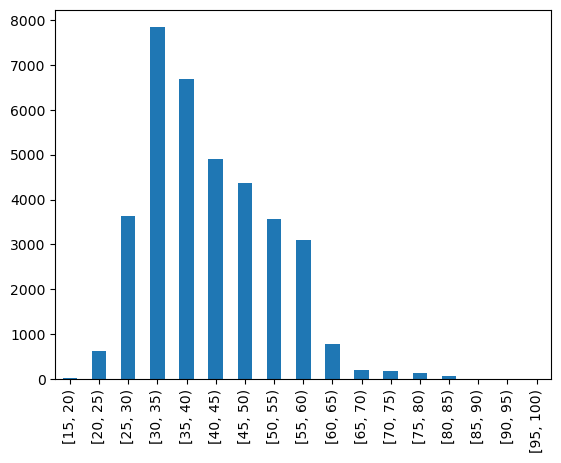

In [6]:
pd.cut(train_df['age'], range(15, 101, 5), right=False).value_counts(sort=False).plot.bar()

<Axes: >

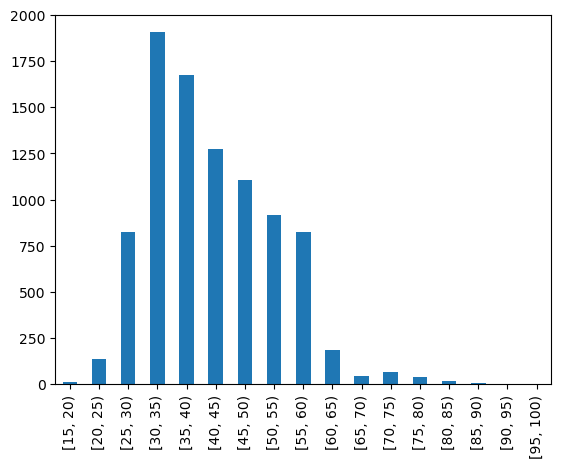

In [7]:
pd.cut(test_df['age'], range(15, 101, 5), right=False).value_counts(sort=False).plot.bar()

@1 なんとなく，15\~30, 30\~40, 40\~60, 60\~ の4つに分けられそうだけど，変な分布じゃないし，一旦前処理無しでいく．

@1 グラフまわり参考: https://qiita.com/hrappuccino/items/16c20645c60578391017

[]

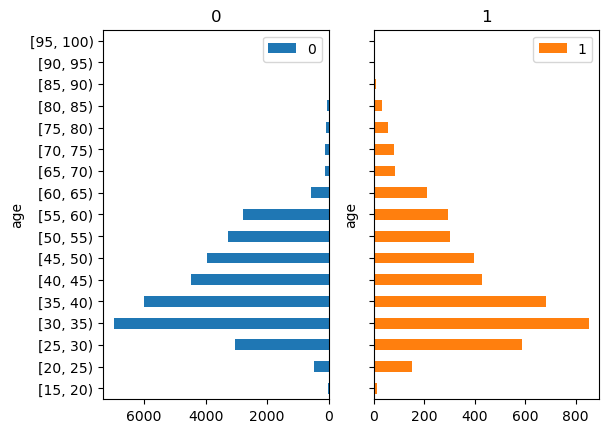

In [8]:
(ax0, ax1), = pd.crosstab(pd.cut(train_df['age'], range(15, 101, 5), right=False), train_df['y']).plot.barh(subplots=True, layout=(1, 2), sharex=False)
ax0.invert_xaxis()
ax1.set_yticklabels([])
[]

@1 90歳近い年寄りでも口座開設してる人がいる．その口座何に使うんだろう．

new レポート課題1の feature importance 的に age あんまり効いてなかったな．education の方が効いてた．

## job

In [9]:
print(pd.value_counts(train_df['job'], dropna=False))
print('----')
print(pd.value_counts(test_df['job'], dropna=False))

blue-collar      7808
management       7489
technician       6099
admin.           4154
services         3352
retired          1784
self-employed    1278
entrepreneur     1198
unemployed       1029
housemaid         992
student           763
NaN               223
Name: job, dtype: int64
----
management       1969
blue-collar      1924
technician       1498
admin.           1017
services          802
retired           480
self-employed     301
entrepreneur      289
unemployed        274
housemaid         248
student           175
NaN                65
Name: job, dtype: int64


@1 分布的にはそんなに変わらない． unemployed とは別に NaN がある．

In [10]:
pd.crosstab(train_df['job'].fillna('nan'), train_df['y'])

y,0,1
job,,
admin.,3659,495
blue-collar,7242,566
entrepreneur,1097,101
housemaid,905,87
management,6464,1025
nan,200,23
retired,1379,405
self-employed,1130,148
services,3057,295


@1 ぱっと見，retired, student が3~4割で突出して多い．やっぱりお年寄りの人，口座開設してる…?

@1 とりあえず one-hot encoding して，その後，retierd と student だけ特別扱いするのも検討．

In [11]:
pd.crosstab(train_df['job'].fillna('nan'), pd.cut(train_df['age'], range(15, 101, 5), right=False))

age,"[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 70)","[70, 75)","[75, 80)","[80, 85)","[85, 90)","[90, 95)","[95, 100)"
job,,,,,,,,,,,,,,,,,
admin.,0,72,554,946,778,567,523,389,259,56,7,2,1,0,0,0,0
blue-collar,0,125,813,1586,1550,1221,1141,789,502,76,2,1,2,0,0,0,0
entrepreneur,0,3,74,218,246,195,178,154,108,17,3,2,0,0,0,0,0
housemaid,0,3,35,108,135,139,150,163,177,53,12,4,5,8,0,0,0
management,0,33,575,1913,1553,1056,855,749,605,121,18,6,3,2,0,0,0
nan,0,0,12,20,24,26,48,31,41,12,4,2,3,0,0,0,0
retired,0,1,2,3,13,28,54,164,651,342,153,166,113,72,17,4,1
self-employed,0,10,137,266,257,188,144,151,88,30,2,3,2,0,0,0,0
services,0,71,431,815,643,478,411,295,193,14,1,0,0,0,0,0,0


@1 なんとなく年齢と職業の分布を見てみる．学生の年齢層が思ったより高い，大学院生ばっかりかもしれない．retiered はやっぱり定年退職が多い．

new レポート課題1の feature importance 的に，retired と student を特別扱いした job はちょっと効いてたな．

## marital

In [12]:
print(pd.value_counts(train_df['marital'], dropna=False))
print('----')
print(pd.value_counts(test_df['marital'], dropna=False))

married     21746
single      10260
divorced     4163
Name: marital, dtype: int64
----
married     5468
single      2530
divorced    1044
Name: marital, dtype: int64


@1 divorced = 離婚した，今回は未亡人も含む．

In [13]:
pd.crosstab(train_df['marital'], train_df['y'])

y,0,1
marital,,
divorced,3666,497
married,19581,2165
single,8734,1526


@1 口座開設まで至った割合で見ると，多い順に，single, divorced, married. 一旦，one-hot encoding してみて，その後，1,2,3と encoding してみたい．

new レポート課題1の結果的に，single,divorced,married=1,2,3 のエンコーディングはちょっと効いてた．

## education

In [14]:
print(pd.value_counts(train_df['education'], dropna=False))
print('----')
print(pd.value_counts(test_df['education'], dropna=False))

secondary    18594
tertiary     10636
primary       5459
NaN           1480
Name: education, dtype: int64
----
secondary    4608
tertiary     2665
primary      1392
NaN           377
Name: education, dtype: int64


@1 特に言うことなし，nan,primary,secondary,tertiary=-1,1,2,3 で encoding すればいいか．

In [15]:
pd.crosstab(train_df['education'].fillna('nan'), train_df['y'])

y,0,1
education,,
nan,1283,197
primary,4995,464
secondary,16634,1960
tertiary,9069,1567


## default
債務不支払いがあるかどうか

In [16]:
print(pd.value_counts(train_df['default'], dropna=False))
print('----')
print(pd.value_counts(test_df['default'], dropna=False))

no     35512
yes      657
Name: default, dtype: int64
----
no     8884
yes     158
Name: default, dtype: int64


In [17]:
pd.crosstab(train_df['default'], train_df['job'].fillna('nan'))

job,admin.,blue-collar,entrepreneur,housemaid,management,nan,retired,self-employed,services,student,technician,unemployed
default,,,,,,,,,,,,
no,4091,7660,1157,975,7348,221,1765,1248,3289,760,5993,1005
yes,63,148,41,17,141,2,19,30,63,3,106,24


@1 なんとなく職業と一緒に出したけど，特に何も分からず． yes,no=1,0 で encoding する．

## balance
@1 残高? 公式の attibute information に記載がない......

0        2803
1         150
2         122
4         112
3          98
         ... 
4719        1
5239        1
4547        1
4490        1
16353       1
Name: balance, Length: 6572, dtype: int64
count    36169.000000
mean      1352.839282
std       3028.926524
min      -6847.000000
25%         70.000000
50%        445.000000
75%       1417.000000
max      98417.000000
Name: balance, dtype: float64


<Axes: ylabel='Frequency'>

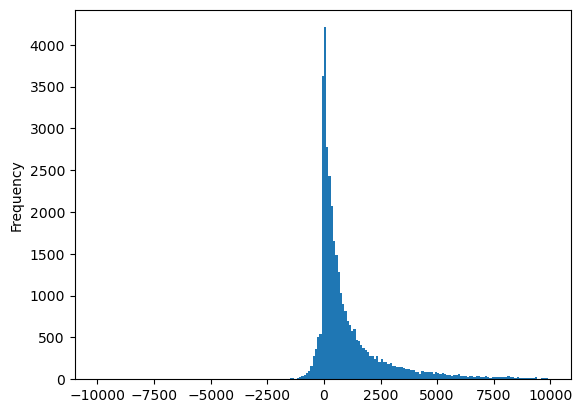

In [18]:
print(pd.value_counts(train_df['balance'], dropna=False))
print(train_df['balance'].describe())
train_df['balance'].plot.hist(bins=range(-9999, 9999, 100))

@1 0 が一番多い．負数になってるやつもある． なんだこれ?

In [19]:
print(pd.crosstab(train_df['balance']>2000, train_df['y']))
print(pd.crosstab((train_df['balance']>=0) & (train_df['balance']<=2000), train_df['y']))
pd.crosstab(train_df['balance']<0, train_df['y'])

y            0     1
balance             
False    26331  3070
True      5650  1118
y            0     1
balance             
False     8537  1282
True     23444  2906


y,0,1
balance,,
False,29094,4024
True,2887,164


@1 とりあえず残高だとして，マイナスが借金だとして，見てみると，それなりに予測に使えそう．だけど，やっぱり，元データに記載されてないのが怖いので，使わないで精度がそれなりに出るなら使わないでおこう．

new 課題1の結果的にけっこう効いてた．

## housing

In [20]:
print(pd.value_counts(train_df['housing'], dropna=False))
print('----')
print(pd.value_counts(test_df['housing'], dropna=False))

yes    20049
no     16120
Name: housing, dtype: int64
----
yes    5081
no     3961
Name: housing, dtype: int64


In [21]:
pd.crosstab(train_df['housing'], train_df['marital'])

marital,divorced,married,single
housing,,,
no,1843,9502,4775
yes,2320,12244,5485


@1 1人身でも家持ってる人多いな．

## loan

In [22]:
print(pd.value_counts(train_df['loan'], dropna=False))
print('----')
print(pd.value_counts(test_df['loan'], dropna=False))

no     30363
yes     5806
Name: loan, dtype: int64
----
no     7604
yes    1438
Name: loan, dtype: int64


In [23]:
pd.crosstab(train_df['loan'], train_df['housing'])

housing,no,yes
loan,,
no,13819,16544
yes,2301,3505


@1 住宅ローンだけじゃないのがいっぱいある．車かなぁ．

## contact
キャンペーンで使ったコンタクト方法

In [24]:
print(pd.value_counts(train_df['contact'], dropna=False))
print('----')
print(pd.value_counts(test_df['contact'], dropna=False))

cellular     23416
NaN          10417
telephone     2336
Name: contact, dtype: int64
----
cellular     5869
NaN          2603
telephone     570
Name: contact, dtype: int64


In [25]:
pd.crosstab(train_df['contact'].fillna('nan'), train_df['housing'])

housing,no,yes
contact,,
cellular,11793,11623
nan,2928,7489
telephone,1399,937


@1 telephone 別に housing yes で多いわけじゃないんだ．というか，nan のときに housing yes が多いな．もしかして，電話だけじゃなくてチラシでもやったんだろうか．

In [26]:
pd.crosstab(train_df['contact'].fillna('nan'), train_df['y'])

y,0,1
contact,,
cellular,19950,3466
nan,10013,404
telephone,2018,318


@1 nan だけ割合がなんか違う．cellular, telephone とそれ以外っていう分け方かな．

new 4番目に効いてた．

## day
@1 元データの attribute information に記載なし．attribute information にはかわりに day_of_week があるけど，逆にこれは csv に含まれてない．最後にキャンペーンをした日 (ここまで偏りのチェックにtrainとtest両方見てたけど，偏りなさそうなので，以降trainだけ見る)

<Axes: >

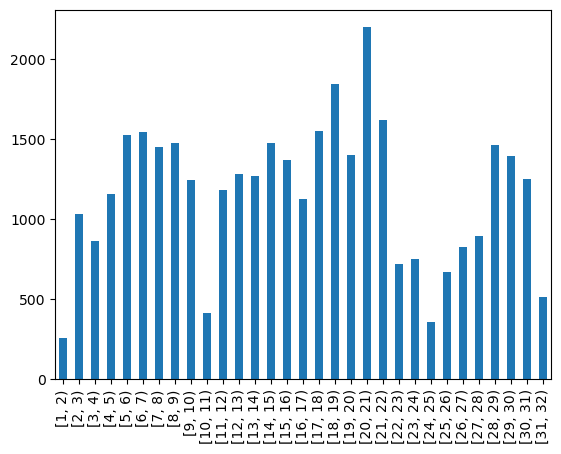

In [27]:
pd.cut(train_df['day'], range(1, 33, 1), right=False).value_counts(sort=False).plot.bar()

@1 日によって出現頻度に偏りがあるが，多分祝日とかの関係で，あまり意味があると思わないので，今回は使わない．

new 課題1でも最終的に使った．結構効いてた．

## month
最後にキャンペーンをした月

In [28]:
print(pd.value_counts(train_df['month'], dropna=False))

may    11013
jul     5516
aug     4998
jun     4273
nov     3175
apr     2346
feb     2119
jan     1122
oct      591
sep      462
mar      382
dec      172
Name: month, dtype: int64


@1 なぜか5月が圧倒的に多い

In [29]:
pd.crosstab(train_df['month'], train_df['y'])

y,0,1
month,,
apr,1880,466
aug,4457,541
dec,92,80
feb,1777,342
jan,1012,110
jul,5012,504
jun,3850,423
mar,185,197
may,10284,729


@1 なんかデータの少ない月が1の割合が多い．あまり共通項が分からない．口座を開設したくなる時期がよくわからない．新生活の準備ってわけじゃなさそう．一旦，count encoding でやってみる．(もしかすると特定の月に偏ってることに意味がないかもしれないけど)

new 3番目に効いてた．なぜこんなに効いてるのか分からない．

## duration
@1 通話時間\ 本来は，通話が終わるまで契約の有無は分からないし，通話が終わったら結果が出てるので，実際の予測に使えない変数．\ 元データでもベンチマーク以外で使わないように注意書きがある．\ 今回は使わないことにする．

new 課題1で使った．

## campaign
何回キャンペーンの呼びかけをしたか．

<Axes: ylabel='Frequency'>

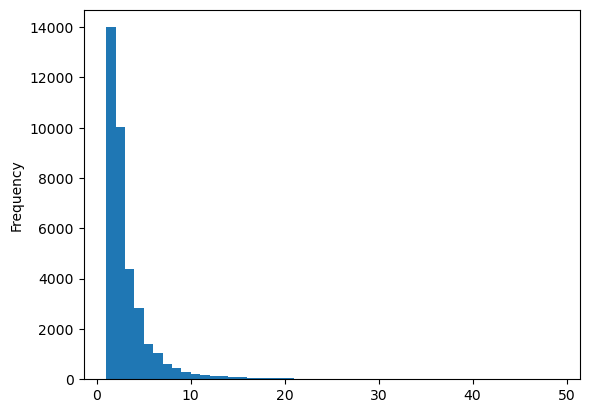

In [30]:
train_df['campaign'].plot.hist(bins=range(1,50))

In [31]:
print(pd.crosstab(train_df['campaign']>1, train_df['y']))
pd.crosstab(train_df['campaign']>10, train_df['y'])

y             0     1
campaign             
False     11967  2027
True      20014  2161


y,0,1
campaign,,
False,31038,4151
True,943,37


@1 回数が多いと，契約される割合は下がりそう．\ 契約する人は一回目のキャンペーンですでに契約してるのかな．\ そのまま入れてみる．



## pdays
前回のキャンペーンで最後に連絡されてから経過した日数．

<Axes: ylabel='Frequency'>

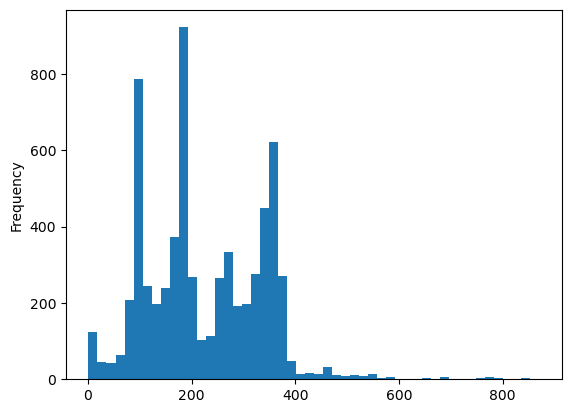

In [32]:
train_df['pdays'].plot.hist(bins=50)

In [33]:
pd.value_counts(train_df['pdays'], dropna=False)

NaN      29616
182.0      133
92.0       109
183.0      100
181.0       93
         ...  
452.0        1
648.0        1
667.0        1
585.0        1
550.0        1
Name: pdays, Length: 531, dtype: int64

In [34]:
pd.crosstab(train_df['pdays'].isna(), train_df['y'])

y,0,1
pdays,,
False,5072,1481
True,26909,2707


In [35]:
pdays_not_na_train_df = train_df[train_df['pdays'].notna()]
print(pd.crosstab(pdays_not_na_train_df['pdays']>100, pdays_not_na_train_df['y']))
print(pd.crosstab(pdays_not_na_train_df['pdays']>200, pdays_not_na_train_df['y']))
print(pd.crosstab(pdays_not_na_train_df['pdays']>500, pdays_not_na_train_df['y']))

y         0    1
pdays           
False   642  487
True   4430  994
y         0     1
pdays            
False  2337  1072
True   2735   409
y         0     1
pdays            
False  5021  1448
True     51    33


@1 単純に日にち増えたからといって1の割合増えるわけでもなさそう．\ 判断に困るので特徴量として不採用．

new 課題1で入れたら多少効いてた… balance とか job よりも効いてた．

## previous
前のキャンペーンで連絡した回数

In [36]:
print(pd.value_counts(train_df['previous'], dropna=False))

0      29616
1       2217
2       1648
3        903
4        577
5        367
6        229
7        166
8         97
9         67
10        53
11        52
12        36
13        28
15        14
17        14
14        13
16        11
19        10
23         7
24         5
22         5
27         4
18         3
21         3
25         3
20         3
38         2
37         2
26         2
30         2
29         2
28         2
51         1
275        1
58         1
32         1
40         1
41         1
Name: previous, dtype: int64


@1 ほぼ 0

In [37]:
pd.crosstab(train_df['previous']==0, train_df['y'])

y,0,1
previous,,
False,5072,1481
True,26909,2707


@1 以前コンタクトした人の方がちょっと割合多い．\ でも，以前コンタクトしたかどうかは，次見る poutcome で分かるしいらなさそう．

## poutcome

In [38]:
print(pd.value_counts(train_df['poutcome'], dropna=False))

NaN        29621
failure     3907
other       1430
success     1211
Name: poutcome, dtype: int64


@1 nan と other って何が違うんだろう? 元データのサイトだと，failure, nonexistent, success の3つだった．

In [39]:
pd.crosstab(train_df['poutcome'].fillna('nan'), train_df['previous']==0)

previous,False,True
poutcome,,
failure,3907,0
nan,5,29616
other,1430,0
success,1211,0


@1 other 本当に other じゃん．過去にキャンペーンはしたけど結果が残ってなかった? previous 0 なのに nan になってるやつもある…

In [40]:
pd.crosstab(train_df['poutcome'].fillna('nan'), train_df['y'])

y,0,1
poutcome,,
failure,3425,482
nan,26912,2709
other,1201,229
success,443,768


@1 さすがに，前回成功してる人は今回もうまくいきそう．それ以外は……ちょっと分からない．success かどうかでまとめちゃってもいいな．

new duration 除いたら一番効いてた．

# モデルの学習
CatBoost でやってみる．

特徴量全部入りでやった後，実際の予測で使わない方がいい変数を消した版も試す．

## 特徴量全部入り
### 特徴量作成

In [41]:
train_test_df = pd.concat([train_df, test_df])

In [42]:
# 課題1 でやった前処理
train_test_df['counted_month'] = train_test_df.groupby('month')['month'].transform('count')

In [43]:
train_test_df['ordered_education'] = train_test_df['education'].map({'primary': 1, 'secondary': 2, 'tertiary': 3})
train_test_df['contact_is_phone'] = train_test_df['contact'].map({'cellular': 1, 'telephone': 1}).fillna(-1).astype(int)
train_test_df['poutcome_is_success'] = train_test_df['poutcome'].map({'success': 1}).fillna(-1).astype(int)
train_test_df['processed_job'] = train_test_df['job'].map({'student': 1, 'retired': 2}).fillna(-1).astype(int)
train_test_df['processed_marital'] = train_test_df['marital'].map({'single': 1, 'divorced': 2, 'married': 3})

processed_categorical = ['contact_is_phone', 'poutcome_is_success', 'processed_job'] # 他の2つは cat_feature に入れない

In [44]:
from sklearn.preprocessing import LabelEncoder

In [45]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# ラベルエンコーディング
le_dict = {}
for c in categorical_columns:
    le = LabelEncoder()
    train_test_df[c] = le.fit_transform(train_test_df[c])
    le_dict[c] = le
    
# 近い月が全然違うデータに見えるのは流石に，グラフが見ずらいので，これは手動でやる
train_test_df['month'] = train_test_df['month'].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
})

train_test_df['pdays'] = train_test_df['pdays'].fillna(-1).astype(int)
train_test_df['previous'] = train_test_df['previous'].fillna(-1).astype(int)
    
categorical_columns += ['month', 'day', 'pdays']

In [46]:
train_test_df.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y', 'counted_month',
       'ordered_education', 'contact_is_phone', 'poutcome_is_success',
       'processed_job', 'processed_marital'],
      dtype='object')

In [47]:
# 学習用の df の作成
train_ft_df = train_test_df[train_test_df['y'].notna()].drop(['id', 'y'], axis=1)
train_y_df = train_test_df[train_test_df['y'].notna()]['y'].astype(int)
test_ft_df = train_test_df[train_test_df['y'].isna()].drop(['id', 'y'], axis=1)

train_X, valid_X, train_y, valid_y = train_test_split(train_ft_df, train_y_df, test_size=0.2, shuffle=True, random_state=22)
train_X

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,counted_month,ordered_education,contact_is_phone,poutcome_is_success,processed_job,processed_marital
1599,35,6,1,1,0,351,1,0,2,9,...,2,-1,0,3,13766,2.0,-1,-1,-1,3
2852,40,1,1,0,0,2562,1,0,2,15,...,4,-1,0,3,13766,1.0,-1,-1,-1,3
35121,50,9,2,2,0,2,0,0,2,10,...,1,-1,0,3,5341,3.0,-1,-1,-1,1
22320,59,5,0,1,0,914,0,0,0,28,...,1,-1,0,3,1403,2.0,1,-1,2,2
1368,59,4,2,1,0,181,1,0,2,9,...,1,-1,0,3,13766,2.0,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20971,41,1,1,0,0,2562,1,0,0,20,...,1,189,4,0,3970,1.0,1,-1,-1,3
23030,45,7,0,1,0,-28,0,1,0,30,...,1,-1,0,3,1403,2.0,1,-1,-1,2
24932,43,0,1,1,0,477,1,0,0,27,...,2,-1,0,3,2649,2.0,1,-1,-1,3
31680,59,4,1,2,0,1831,0,0,0,26,...,2,98,2,0,13766,3.0,1,-1,-1,3


In [48]:
from catboost import CatBoostClassifier, Pool

In [49]:
allin_clf_cat = CatBoostClassifier(iterations=1000, loss_function='Logloss', cat_features=categorical_columns+processed_categorical, eval_metric='AUC')
allin_clf_cat.fit(train_X, train_y, eval_set=(valid_X, valid_y), early_stopping_rounds=10, logging_level='Verbose')

Learning rate set to 0.072758
0:	test: 0.8351775	best: 0.8351775 (0)	total: 129ms	remaining: 2m 9s
1:	test: 0.8480780	best: 0.8480780 (1)	total: 192ms	remaining: 1m 35s
2:	test: 0.8812474	best: 0.8812474 (2)	total: 248ms	remaining: 1m 22s
3:	test: 0.8894382	best: 0.8894382 (3)	total: 308ms	remaining: 1m 16s
4:	test: 0.8960717	best: 0.8960717 (4)	total: 366ms	remaining: 1m 12s
5:	test: 0.8951402	best: 0.8960717 (4)	total: 397ms	remaining: 1m 5s
6:	test: 0.8967317	best: 0.8967317 (6)	total: 449ms	remaining: 1m 3s
7:	test: 0.8970396	best: 0.8970396 (7)	total: 490ms	remaining: 1m
8:	test: 0.8982540	best: 0.8982540 (8)	total: 546ms	remaining: 1m
9:	test: 0.9004822	best: 0.9004822 (9)	total: 605ms	remaining: 59.9s
10:	test: 0.9055314	best: 0.9055314 (10)	total: 666ms	remaining: 59.8s
11:	test: 0.9116009	best: 0.9116009 (11)	total: 720ms	remaining: 59.3s
12:	test: 0.9127743	best: 0.9127743 (12)	total: 765ms	remaining: 58.1s
13:	test: 0.9152744	best: 0.9152744 (13)	total: 823ms	remaining: 58s


In [50]:
pred_test = allin_clf_cat.predict_proba(test_ft_df)[:, 1]
sub_df = pd.DataFrame({
    'id': test_df['id'],
    'pred': pred_test
}).to_csv("tanaka_sub_cat_allin.csv", index=False)

public score 0.937 他のモデル使ってみたら上がるかな?

まぁでも，精度出すのが目的じゃないので，いいか．

## 全部入りモデルの解釈

## feature importance

Text(0.5, 0, 'Feature Importance')

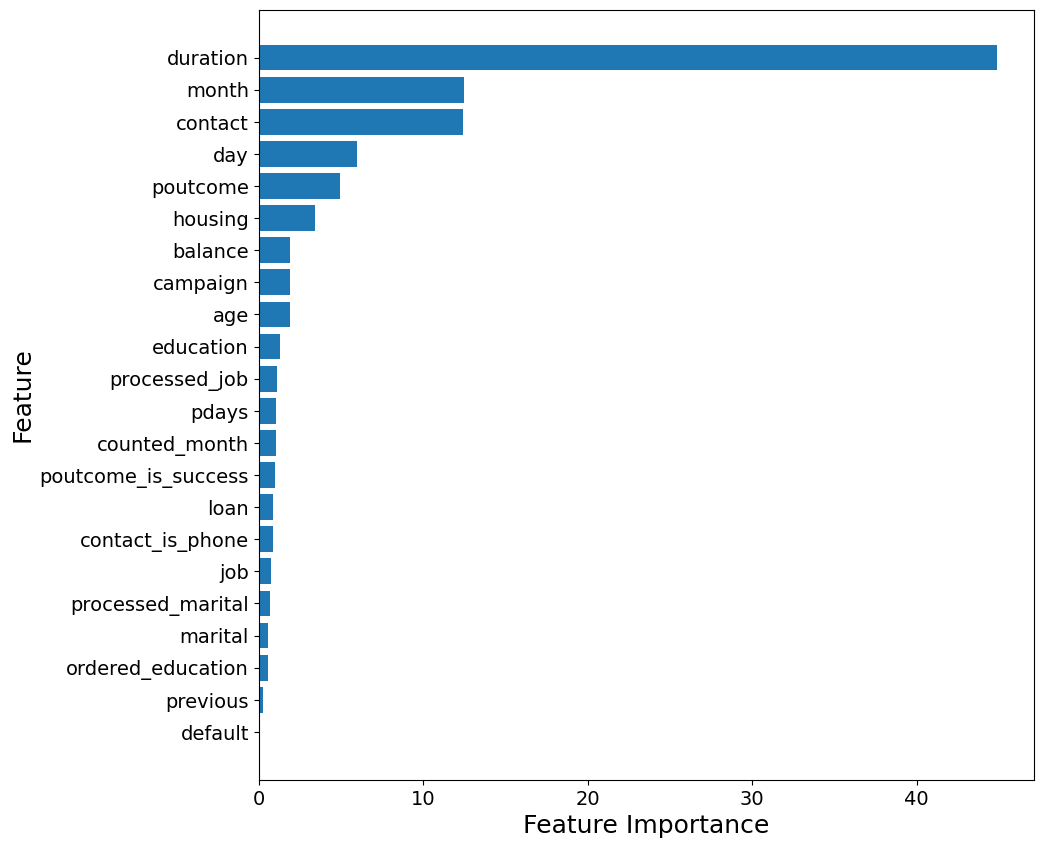

In [51]:
import matplotlib.pyplot as plt

feature = allin_clf_cat.feature_importances_
label = train_X.columns
indices = np.argsort(feature)

# 特徴量の重要度の棒グラフ
fig =plt.figure (figsize = (10,10))

plt.barh(range(len(feature)), feature[indices])

plt.yticks(range(len(feature)), label[indices], fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Feature", fontsize=18)
plt.xlabel("Feature Importance", fontsize=18)

ただの決定木と大体同じ．

poutcome の importance が比較的下がっている．

## SHAP: summary plot

In [52]:
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [53]:
explainer = shap.TreeExplainer(allin_clf_cat)
shap_values = explainer.shap_values(train_X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


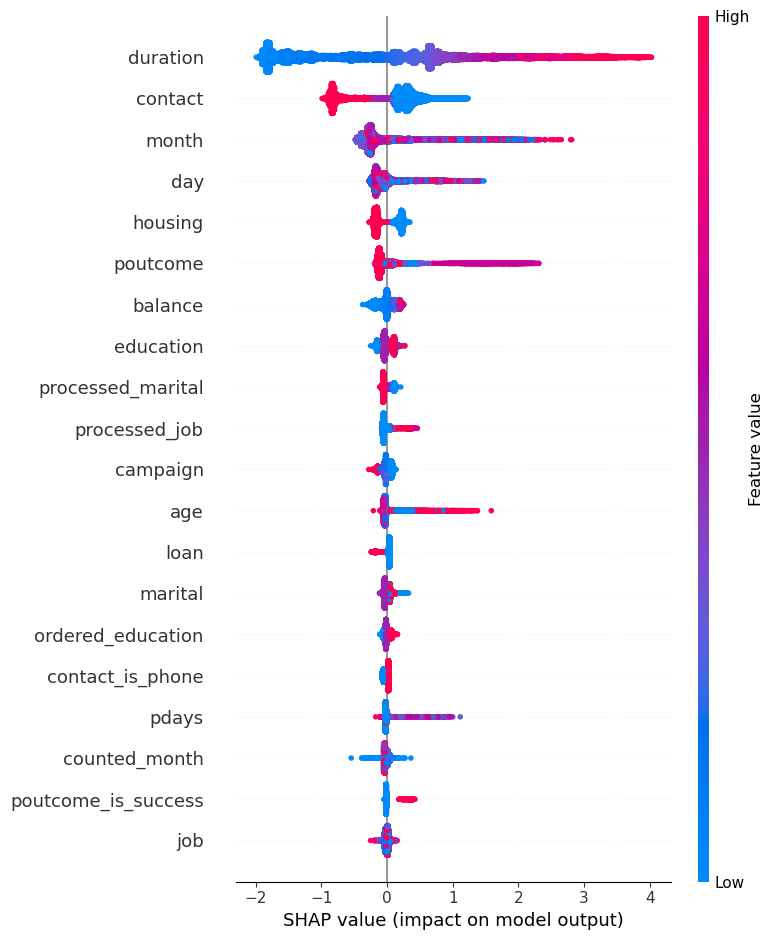

In [54]:
shap.summary_plot(shap_values, train_X)

SHAP も feature importance も duration が圧倒的に影響強い．

duration 除くと，contact がきれいに別れていて強い．contact の方法で変わるのはどうして?

housing も赤と青きれいに別れている．

poutcome_is_success や processed_job がきれいにわかれてるのを見る感じ，きれいに前処理できてるのがわかる．

あとは，意外と，age や pdays の影響も強い．

## SHAP: force plot

In [55]:
shap.force_plot(explainer.expected_value, shap_values[:100], train_X[:100])

まず，duration の影響を見る．y軸 duration effects, x軸 duration にしてグラフを見ると，見事に，duration が増えるほど，出力が正の方向に振れている．

(キャンペーンに申し込む気ないと，さっさと電話切るだろうし，キャンペーン申し込む場合は契約の話とかあるから長くなるんだろう)

次に，contact の影響を見る．y軸 contact effects, x軸 contact にしてグラフを見ると，contact 0 で正，contact 2 で負に触れている．

In [56]:
print(le_dict['contact'].classes_)

['cellular' 'telephone' nan]


contact 0 = cellular で， 2 = nan なので，携帯電話にかけた方が，成功率が高いのが分かる．（なぜそうなるのか，なぜ nan が入っているのかはわからない）

次に，month も見てみる．y軸 month effects, x軸 month にすると，3, 10月は正の影響が大きいのが分かる．

4月のときの効果が小さいのはともかく，卒業入学シーズンで正に値が触れている．

In [57]:
print(le_dict['job'].classes_)

['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' nan]


job の値で見ると，job=8 つまり student が正の影響を持ってるので，やっぱり，学生相手にキャンペーンするのが良さそう．

最後に山が一番デカい，90番目の値の forceplot を見てみる．

In [58]:
shap.force_plot(explainer.expected_value, shap_values[90,:], train_X.iloc[90, :])

In [59]:
print(le_dict['poutcome'].classes_)

['failure' 'other' 'success' nan]


# Q4「このデータを元にして機械学習モデルを作って、将来のデータを用いてマーケティングを行う。このときモデルに使うべきでないと考えられる特徴はあるか、理由とともに答えなさい。」に対する答え
絶対に使ってはいけない特徴量：duration

理由：元データの説明にもある通り，その人にキャンペーンを持ちかけた後にしかわからない特徴量だから．マーケティングの施策として，どういう人にセールスの電話をすればいいかということを知りたいのに，電話した時間という電話の後にしか判明しない特徴量を使っても意味がない．さらに，今回 duration 入りで作成したモデルから分かるように，「duration が長い = 高確率で契約成立」といえる．これも，契約成立時に手続きについて説明があるせいだと推察できる．そのため，通話時間を長くできれば契約成立するわけではないので，施策に反映できない．

使わない方がいい特徴量：day

day の理由：特定の祝日・イベント・曜日などと連動している場合を除いて，「特定の日のキャンペーンの成果が高い」のは偶然の可能性が高いため．特定の日が予測に有効なのは，クリスマスなどの日付の決まったイベントかポッキーの日などの語呂合わせくらいだが，本データは銀行の口座開設のキャンペーンなので，語呂合わせやイベントで開設が増えるのは考えにくい．過学習のもとになるため，day ではなく，休日かどうかなど，他の特徴量を使った方がいい．


解釈に注意が必要な特徴量：month

month の理由：各月のデータ数がバラバラのため，解釈に注意が必要なため．各月ごとのキャンペーンの対象が，ランダムに選ばれているなら month も使っていい．しかし，今回のデータでは 5月のデータが多いなど偏りが見られた．この偏りの理由が例えば，「5月は新規の顧客がたくさん欲しいから今までコンタクトしてない層にもコンタクトした」などであれば，5月にキャンペーンを持ちかけることに特に意味はないため予測に使っても仕方がない．一方で，今回3,9,10月がモデルの出力に正の影響をもっており，一応新生活などの理由付けができる．このように，世間の季節イベントと合わせて効果が解釈できる場合は，積極的にmonthを使うべきである．

## duration と day を除いてモデルを作ってみる

In [60]:
train_test_df = pd.concat([train_df, test_df])

In [61]:
train_test_df['counted_month'] = train_test_df.groupby('month')['month'].transform('count')

In [62]:
train_test_df['ordered_education'] = train_test_df['education'].map({'primary': 1, 'secondary': 2, 'tertiary': 3})
train_test_df['contact_is_phone'] = train_test_df['contact'].map({'cellular': 1, 'telephone': 1}).fillna(-1).astype(int)
train_test_df['poutcome_is_success'] = train_test_df['poutcome'].map({'success': 1}).fillna(-1).astype(int)
train_test_df['processed_job'] = train_test_df['job'].map({'student': 1, 'retired': 2}).fillna(-1).astype(int)
train_test_df['processed_marital'] = train_test_df['marital'].map({'single': 1, 'divorced': 2, 'married': 3})

processed_categorical = ['contact_is_phone', 'poutcome_is_success', 'processed_job'] # 他の2つは cat_feature に入れない

In [63]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# ラベルエンコーディング
le_dict = {}
for c in categorical_columns:
    le = LabelEncoder()
    train_test_df[c] = le.fit_transform(train_test_df[c])
    le_dict[c] = le
    
# 近い月が全然違うデータに見えるのは流石に，グラフが見ずらいので，これは手動でやる
train_test_df['month'] = train_test_df['month'].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
})

train_test_df['pdays'] = train_test_df['pdays'].fillna(-1).astype(int)
train_test_df['previous'] = train_test_df['previous'].fillna(-1).astype(int)
    
categorical_columns += ['month', 'pdays']

In [64]:
train_ft_df = train_test_df[train_test_df['y'].notna()].drop(['id', 'y', 'duration', 'day'], axis=1)
train_y_df = train_test_df[train_test_df['y'].notna()]['y'].astype(int)
test_ft_df = train_test_df[train_test_df['y'].isna()].drop(['id', 'y', 'duration', 'day'], axis=1)

train_X, valid_X, train_y, valid_y = train_test_split(train_ft_df, train_y_df, test_size=0.2, shuffle=True, random_state=22)
train_X

,age,job,marital,education,default,balance,housing,loan,contact,month,campaign,pdays,previous,poutcome,counted_month,ordered_education,contact_is_phone,poutcome_is_success,processed_job,processed_marital
1599,35,6,1,1,0,351,1,0,2,5,2,-1,0,3,13766,2.0,-1,-1,-1,3
2852,40,1,1,0,0,2562,1,0,2,5,4,-1,0,3,13766,1.0,-1,-1,-1,3
35121,50,9,2,2,0,2,0,0,2,6,1,-1,0,3,5341,3.0,-1,-1,-1,1
22320,59,5,0,1,0,914,0,0,0,1,1,-1,0,3,1403,2.0,1,-1,2,2
1368,59,4,2,1,0,181,1,0,2,5,1,-1,0,3,13766,2.0,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20971,41,1,1,0,0,2562,1,0,0,11,1,189,4,0,3970,1.0,1,-1,-1,3
23030,45,7,0,1,0,-28,0,1,0,1,1,-1,0,3,1403,2.0,1,-1,-1,2
24932,43,0,1,1,0,477,1,0,0,2,2,-1,0,3,2649,2.0,1,-1,-1,3
31680,59,4,1,2,0,1831,0,0,0,5,2,98,2,0,13766,3.0,1,-1,-1,3


In [65]:
reduced_clf_cat = CatBoostClassifier(iterations=1000, loss_function='Logloss', cat_features=categorical_columns+processed_categorical, eval_metric='AUC')
reduced_clf_cat.fit(train_X, train_y, eval_set=(valid_X, valid_y), early_stopping_rounds=10, logging_level='Verbose')

Learning rate set to 0.072758
0:	test: 0.6989849	best: 0.6989849 (0)	total: 39.4ms	remaining: 39.3s
1:	test: 0.7390113	best: 0.7390113 (1)	total: 83.1ms	remaining: 41.5s
2:	test: 0.7411297	best: 0.7411297 (2)	total: 114ms	remaining: 37.9s
3:	test: 0.7411297	best: 0.7411297 (2)	total: 132ms	remaining: 32.9s
4:	test: 0.7507112	best: 0.7507112 (4)	total: 183ms	remaining: 36.5s
5:	test: 0.7521294	best: 0.7521294 (5)	total: 221ms	remaining: 36.7s
6:	test: 0.7539935	best: 0.7539935 (6)	total: 259ms	remaining: 36.7s
7:	test: 0.7541029	best: 0.7541029 (7)	total: 307ms	remaining: 38s
8:	test: 0.7687450	best: 0.7687450 (8)	total: 347ms	remaining: 38.2s
9:	test: 0.7720722	best: 0.7720722 (9)	total: 398ms	remaining: 39.4s
10:	test: 0.7746169	best: 0.7746169 (10)	total: 445ms	remaining: 40s
11:	test: 0.7746487	best: 0.7746487 (11)	total: 474ms	remaining: 39s
12:	test: 0.7737683	best: 0.7746487 (11)	total: 520ms	remaining: 39.5s
13:	test: 0.7747708	best: 0.7747708 (13)	total: 567ms	remaining: 39.9s


さすがに，大分精度が落ちる．

In [66]:
pred_test = reduced_clf_cat.predict_proba(test_ft_df)[:, 1]
sub_df = pd.DataFrame({
    'id': test_df['id'],
    'pred': pred_test
}).to_csv("tanaka_sub_cat_reduced.csv", index=False)

### モデルの解釈

Text(0.5, 0, 'Feature Importance')

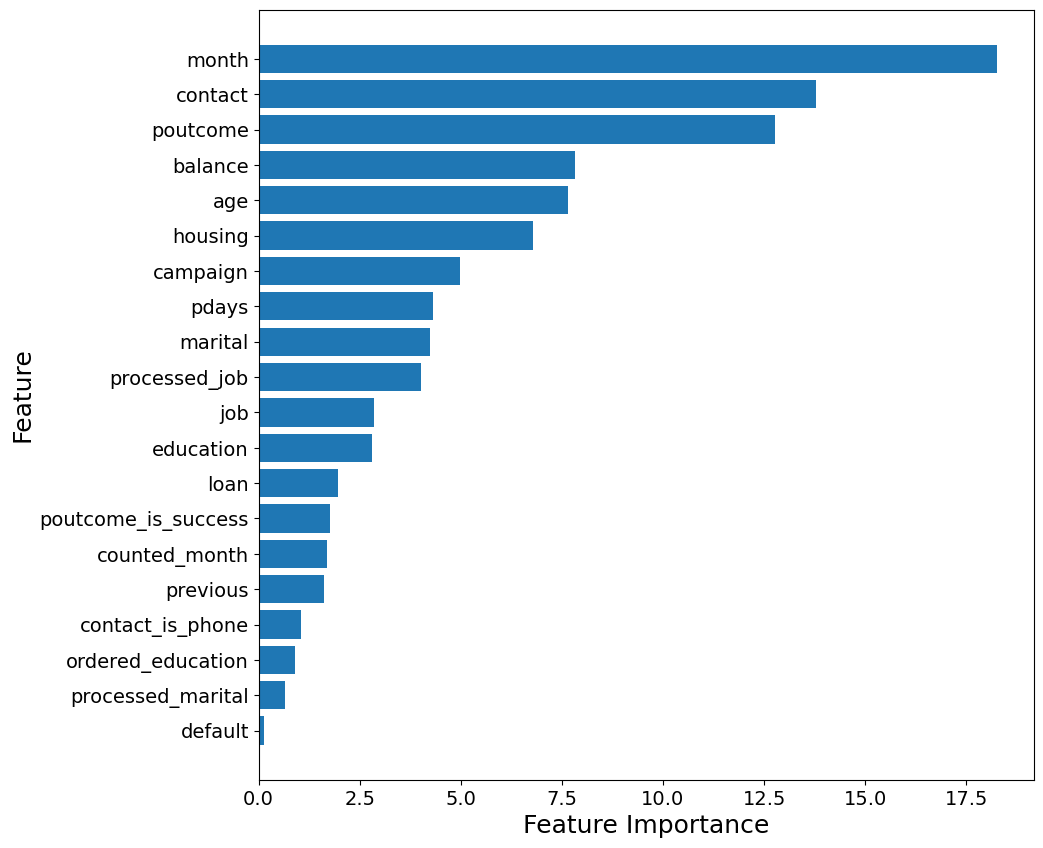

In [67]:
feature = reduced_clf_cat.feature_importances_
label = train_X.columns
indices = np.argsort(feature)

# 特徴量の重要度の棒グラフ
fig =plt.figure (figsize = (10,10))

plt.barh(range(len(feature)), feature[indices])

plt.yticks(range(len(feature)), label[indices], fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Feature", fontsize=18)
plt.xlabel("Feature Importance", fontsize=18)

順序自体はあんまり変わらない気がする．

default まったく関係ない……

In [68]:
explainer = shap.TreeExplainer(reduced_clf_cat)
shap_values = explainer.shap_values(train_X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


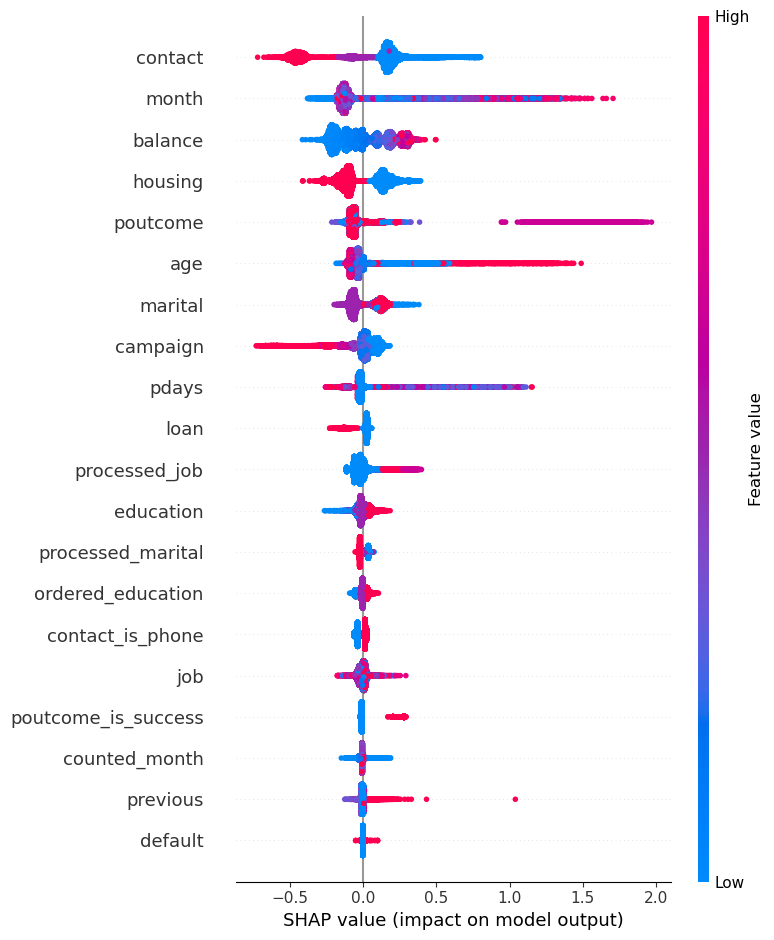

In [69]:
shap.summary_plot(shap_values, train_X)

全部入りのモデルで見れなかった部分としては，campaign がある．

In [70]:
shap.force_plot(explainer.expected_value, shap_values[:100], train_X[:100])

campaign を見ると，回数が増えるほど負の影響が出ている．

契約してくれるような人は何回もキャンペーンを断らないということだろう．

今回も最後に，もっとも出力の大きいパターンのやつを見てみる．

In [71]:
shap.force_plot(explainer.expected_value, shap_values[69,:], train_X.iloc[69, :])